# Finding Feature Importance

In [38]:
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap

shap.initjs()

In [2]:
data = pd.read_csv('BlackFriday.csv')
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


# Handling null values and string variables

In [4]:
df = data.copy()

for column in df.columns:
    if df[column].isnull().sum():
        df[column+'_is_null'] = df[column].isnull()
        df[column].fillna(df[column].mean(),inplace=True)
        
cat_cols = df.select_dtypes('object').columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.astype('category').cat.codes)

In [5]:
X,y = df.drop('Purchase',axis=1), df['Purchase']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Training Model and Finding Feature Importance

In [7]:
rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,max_features='sqrt')
% time rf.fit(X_train,y_train)
rf.score(X_test,y_test)

CPU times: user 27.6 s, sys: 672 ms, total: 28.3 s
Wall time: 29.3 s


0.693129930126831

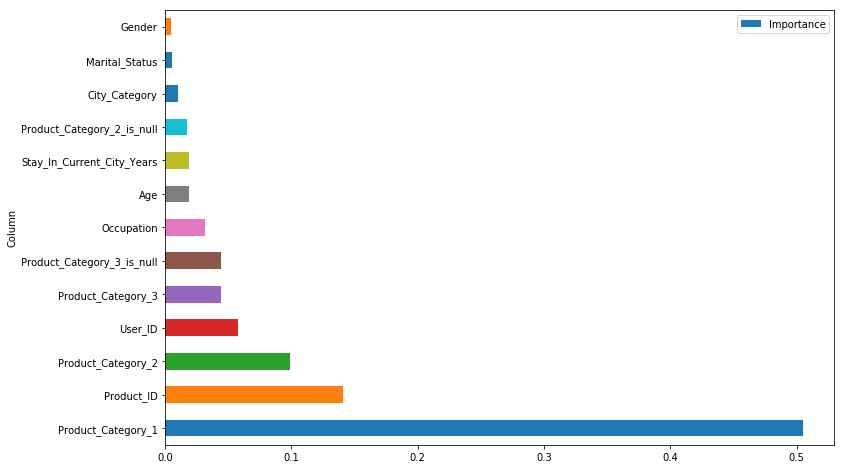

In [8]:
fi = pd.DataFrame({'Column':X.columns,'Importance':rf.feature_importances_}).sort_values('Importance',ascending=False)
fi.plot('Column','Importance','barh',figsize=(12,8))
plt.show()

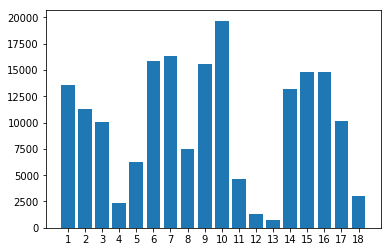

In [9]:
def feature_means(df,feature,label):
    means = {}
    vals = np.sort(df[feature].unique())
    for val in vals:
        val_mean = df[df[feature] == val][label].mean()
        means[val]=val_mean
    
    fig = plt.figure()
    x = np.linspace(1,len(means),len(means))
    plt.bar(means.keys(),means.values())
    plt.xticks(x)
    plt.show()
    
feature_means(df,'Product_Category_1','Purchase')

In [10]:
def feature_means(df,feature,label):
    means = {}
    vals = np.sort(df[feature].unique())
    for val in vals:
        val_mean = df[df[feature] == val][label].mean()
        means[val]=val_mean
    return means

mean_price = feature_means(df,'Product_Category_1','Purchase')
list(mean_price.values())

[13607.701495450045,
 11255.680752372442,
 10096.841704871782,
 2328.8628857957983,
 6238.004044632282,
 15837.893572703828,
 16373.830152671755,
 7497.354849641494,
 15538.29702970297,
 19679.974364069953,
 4682.933555926545,
 1351.1956129032258,
 722.6194852941177,
 13145.452,
 14776.42221505723,
 14764.157471382901,
 10156.440917107584,
 2975.307642276423]

# One Hot Encoding on Product Category 1

In [11]:
cat1_dums = pd.get_dummies(df['Product_Category_1'],prefix='Cat1')
dums_df = df.join(cat1_dums).copy()
dums_df.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase',
       'Product_Category_2_is_null', 'Product_Category_3_is_null', 'Cat1_1',
       'Cat1_2', 'Cat1_3', 'Cat1_4', 'Cat1_5', 'Cat1_6', 'Cat1_7', 'Cat1_8',
       'Cat1_9', 'Cat1_10', 'Cat1_11', 'Cat1_12', 'Cat1_13', 'Cat1_14',
       'Cat1_15', 'Cat1_16', 'Cat1_17', 'Cat1_18'],
      dtype='object')

In [12]:
cols = ['User_ID','Cat1_1','Cat1_2', 'Cat1_3', 'Cat1_4', 'Cat1_5', 'Cat1_6', 'Cat1_7', 'Cat1_8','Cat1_9',
        'Cat1_10', 'Cat1_11', 'Cat1_12', 'Cat1_13', 'Cat1_14','Cat1_15', 'Cat1_16', 'Cat1_17', 'Cat1_18','Purchase']
dums_df = dums_df[cols]
dums_df = dums_df.groupby('User_ID').sum()
dums_df.head()

,Cat1_1,Cat1_2,Cat1_3,Cat1_4,Cat1_5,Cat1_6,Cat1_7,Cat1_8,Cat1_9,Cat1_10,Cat1_11,Cat1_12,Cat1_13,Cat1_14,Cat1_15,Cat1_16,Cat1_17,Cat1_18,Purchase
User_ID,,,,,,,,,,,,,,,,,,,
1000001,4.0,1.0,11.0,2.0,2.0,1.0,0.0,8.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,333481
1000002,31.0,1.0,0.0,0.0,13.0,6.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,810353
1000003,15.0,2.0,1.0,0.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,341635
1000004,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205987
1000005,18.0,2.0,1.0,3.0,20.0,6.0,5.0,44.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,821001


In [13]:
dums_df.drop('Purchase',axis=1,inplace=True)

In [14]:
dums_df.describe()

,Cat1_1,Cat1_2,Cat1_3,Cat1_4,Cat1_5,Cat1_6,Cat1_7,Cat1_8,Cat1_9,Cat1_10,Cat1_11,Cat1_12,Cat1_13,Cat1_14,Cat1_15,Cat1_16,Cat1_17,Cat1_18
count,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000
mean,23.485486,3.988966,3.369377,1.963504,25.223561,3.422848,0.622645,19.034459,0.068579,0.854184,4.067221,0.657783,0.923443,0.254626,1.052962,1.646070,0.096249,0.521983
std,29.572935,5.925088,5.532620,3.611601,32.962789,4.828496,1.710456,26.357024,0.252759,1.523096,9.231519,1.581949,1.720666,0.727353,1.972023,3.024996,0.402544,1.451766
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.000000,2.000000,1.000000,1.000000,12.000000,2.000000,0.000000,9.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,31.000000,5.000000,4.000000,2.000000,31.000000,5.000000,0.000000,23.000000,0.000000,1.000000,4.000000,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000
max,209.000000,53.000000,44.000000,41.000000,273.000000,49.000000,23.000000,276.000000,1.000000,13.000000,124.000000,17.000000,19.000000,15.000000,22.000000,38.000000,5.000000,16.000000


# Analyzing Most Profitable Products

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text xticklabel objects>)

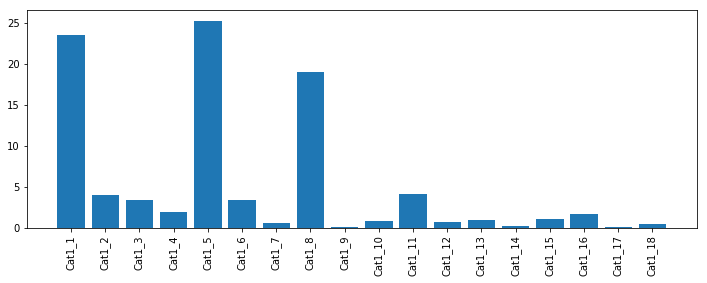

In [15]:
fig = plt.figure(figsize=(12,4))
plt.bar(dums_df.columns,dums_df.describe().loc['mean',:])
plt.xticks(rotation='vertical')

In [16]:
price_analyze = pd.DataFrame({'Product':dums_df.columns,'Amount_sold':dums_df.sum().values.astype('int'),
              'Avg_price':np.round(list(mean_price.values()),2)})
price_analyze['total_sales'] =  price_analyze['Amount_sold'] * price_analyze['Avg_price']
price_analyze

,Product,Amount_sold,Avg_price,total_sales
0,Cat1_1,138353,13607.70,1.882666e+09
1,Cat1_2,23499,11255.68,2.644972e+08
2,Cat1_3,19849,10096.84,2.004122e+08
3,Cat1_4,11567,2328.86,2.693792e+07
4,Cat1_5,148592,6238.00,9.269169e+08
5,Cat1_6,20164,15837.89,3.193552e+08
6,Cat1_7,3668,16373.83,6.005921e+07
7,Cat1_8,112132,7497.35,8.406929e+08
8,Cat1_9,404,15538.30,6.277473e+06
9,Cat1_10,5032,19679.97,9.902961e+07


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text xticklabel objects>)

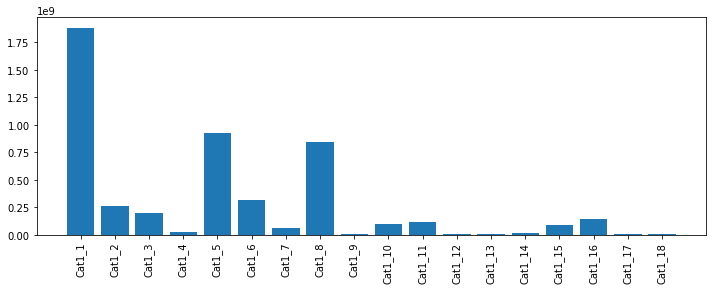

In [17]:
fig = plt.figure(figsize=(12,4))
plt.bar(price_analyze.Product,price_analyze.total_sales)
plt.xticks(rotation='vertical')

# Clustering

## Selecting Samples

In [18]:
indices = [1000017,1000010,1000021]
samples = pd.DataFrame(dums_df.loc[indices],
                       columns=dums_df.columns).reset_index(drop=True)
samples

,Cat1_1,Cat1_2,Cat1_3,Cat1_4,Cat1_5,Cat1_6,Cat1_7,Cat1_8,Cat1_9,Cat1_10,Cat1_11,Cat1_12,Cat1_13,Cat1_14,Cat1_15,Cat1_16,Cat1_17,Cat1_18
0,37.0,7.0,3.0,1.0,13.0,8.0,0.0,19.0,1.0,3.0,8.0,0.0,2.0,0.0,12.0,0.0,0.0,0.0
1,46.0,19.0,16.0,7.0,80.0,2.0,1.0,40.0,0.0,0.0,1.0,6.0,1.0,2.0,0.0,0.0,1.0,0.0
2,4.0,2.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


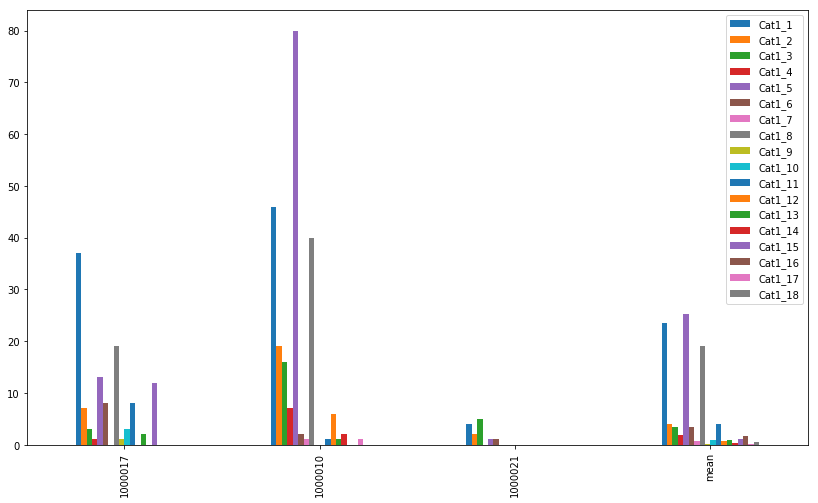

In [19]:
mean_data = dums_df.describe().loc['mean',:]

samples_bar = samples.append(mean_data)

samples_bar.index = indices +['mean']
samples_bar.plot(kind='bar',figsize=(14,8))

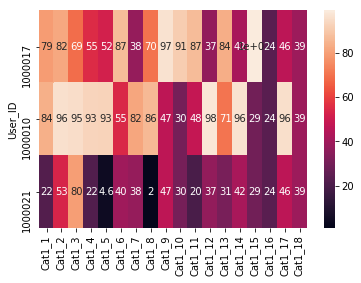

In [20]:
percentiles = dums_df.rank(pct=True)
percentiles = 100*percentiles.round(decimals=3)
percentiles = percentiles.loc[indices,:]
# Now, create the heat map using the seaborn library
sns.heatmap(percentiles, vmin=1, vmax=99, annot=True)

## Feature Relevance

In [21]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [22]:
dep_vars = list(dums_df.columns)

for dv in dep_vars:
    X = dums_df.drop(dv,axis=1)
    y = dums_df[dv]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)
    
    dtr = DecisionTreeRegressor(random_state=42)
    dtr.fit(X_train, y_train)
    score = dtr.score(X_test, y_test)
    
    print(('R2 score for {} as dependent variable: {}'.format(dv, score)))

R2 score for Cat1_1 as dependent variable: 0.40767668692906056
R2 score for Cat1_2 as dependent variable: 0.5528450222205785
R2 score for Cat1_3 as dependent variable: 0.0488027388422817
R2 score for Cat1_4 as dependent variable: 0.3913581925440563
R2 score for Cat1_5 as dependent variable: 0.5164085894828037
R2 score for Cat1_6 as dependent variable: 0.3269179349757345
R2 score for Cat1_7 as dependent variable: -0.2518007666859934
R2 score for Cat1_8 as dependent variable: 0.564733812122772
R2 score for Cat1_9 as dependent variable: -0.5657168470256768
R2 score for Cat1_10 as dependent variable: -0.11808628908532692
R2 score for Cat1_11 as dependent variable: -0.2484661169703717
R2 score for Cat1_12 as dependent variable: -0.4140200655062687
R2 score for Cat1_13 as dependent variable: 0.15479588877287276
R2 score for Cat1_14 as dependent variable: -1.047039085940849
R2 score for Cat1_15 as dependent variable: -0.05411881189010215
R2 score for Cat1_16 as dependent variable: 0.331599249

## Visualize Distributions

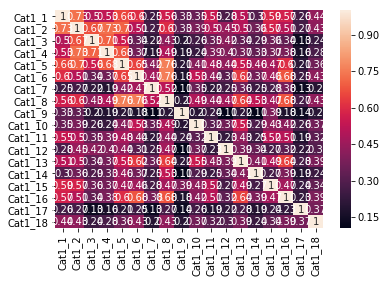

In [28]:
sns.heatmap(dums_df.corr(),annot=True)
plt.show()

## Pre-processing and normalizing

In [42]:
log_samples = np.log(samples.replace(to_replace=0.0,value=0.000001))

log_data = np.log(dums_df.replace(to_replace=0.0,value=0.000001))
display(log_samples)
display(log_data.head())

,Cat1_1,Cat1_2,Cat1_3,Cat1_4,Cat1_5,Cat1_6,Cat1_7,Cat1_8,Cat1_9,Cat1_10,Cat1_11,Cat1_12,Cat1_13,Cat1_14,Cat1_15,Cat1_16,Cat1_17,Cat1_18
0,3.610918,1.945910,1.098612,0.000000,2.564949,2.079442,-13.815511,2.944439,0.000000,1.098612,2.079442,-13.815511,0.693147,-13.815511,2.484907,-13.815511,-13.815511,-13.815511
1,3.828641,2.944439,2.772589,1.945910,4.382027,0.693147,0.000000,3.688879,-13.815511,-13.815511,0.000000,1.791759,0.000000,0.693147,-13.815511,-13.815511,0.000000,-13.815511
2,1.386294,0.693147,1.609438,-13.815511,0.000000,0.000000,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511


,Cat1_1,Cat1_2,Cat1_3,Cat1_4,Cat1_5,Cat1_6,Cat1_7,Cat1_8,Cat1_9,Cat1_10,Cat1_11,Cat1_12,Cat1_13,Cat1_14,Cat1_15,Cat1_16,Cat1_17,Cat1_18
User_ID,,,,,,,,,,,,,,,,,,
1000001,1.386294,0.000000,2.397895,0.693147,0.693147,0.000000,-13.815511,2.079442,-13.815511,-13.815511,-13.815511,1.098612,-13.815511,0.000000,-13.815511,0.000000,-13.815511,-13.815511
1000002,3.433987,0.000000,-13.815511,-13.815511,2.564949,1.791759,-13.815511,3.218876,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511
1000003,2.708050,0.693147,0.000000,-13.815511,2.197225,-13.815511,-13.815511,0.000000,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,0.000000
1000004,2.564949,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511
1000005,2.890372,0.693147,0.000000,1.098612,2.995732,1.791759,1.609438,3.784190,-13.815511,-13.815511,0.693147,-13.815511,-13.815511,0.000000,0.000000,1.098612,-13.815511,-13.815511


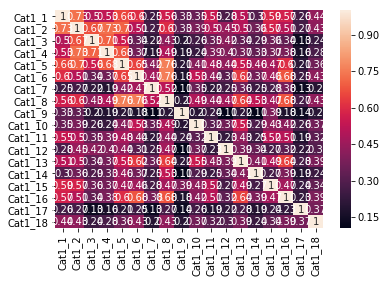

In [44]:
sns.heatmap(dums_df.corr(),annot=True)
plt.show()

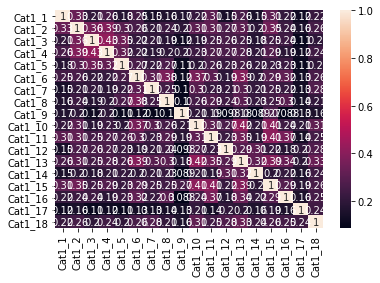

In [45]:
sns.heatmap(log_data.corr(),annot=True)
plt.show()

In [59]:
# Select the indices for data points you wish to remove
outliers_lst  = []

# For each feature find the data points with extreme high or low values
for feature in log_data.columns:
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data.loc[:, feature], 25)

    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data.loc[:, feature], 75)

    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)

    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))

    # The tilde sign ~ means not
    # So here, we're finding any points outside of Q1 - step and Q3 + step
    outliers_rows = log_data.loc[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step)), :]
    # display(outliers_rows)

    outliers_lst.append(list(outliers_rows.index))

outliers = list(itertools.chain.from_iterable(outliers_lst))

# List of unique outliers
# We use set()
# Sets are lists with no duplicate entries
uniq_outliers = list(set(outliers))

# List of duplicate outliers
dup_outliers = list(set([x for x in outliers if outliers.count(x) > 1]))

print('Outliers list:\n', uniq_outliers)
print('Length of outliers list:\n', len(uniq_outliers))

print('Duplicate list:\n', dup_outliers)
print('Length of duplicates list:\n', len(dup_outliers))

# Remove duplicate outliers
# Only 5 specified
good_data = log_data.drop(dup_outliers,axis=0).reset_index(drop = True)

# Original Data 
print('Original shape of data:\n', dums_df.shape)
# Processed Data
print('New shape of data:\n', good_data.shape)

Data points considered outliers for the feature 'Cat1_1':
Data points considered outliers for the feature 'Cat1_2':
Data points considered outliers for the feature 'Cat1_3':
Data points considered outliers for the feature 'Cat1_4':
Data points considered outliers for the feature 'Cat1_5':
Data points considered outliers for the feature 'Cat1_6':
Data points considered outliers for the feature 'Cat1_7':
Data points considered outliers for the feature 'Cat1_8':
Data points considered outliers for the feature 'Cat1_9':
Data points considered outliers for the feature 'Cat1_10':
Data points considered outliers for the feature 'Cat1_11':
Data points considered outliers for the feature 'Cat1_12':
Data points considered outliers for the feature 'Cat1_13':
Data points considered outliers for the feature 'Cat1_14':
Data points considered outliers for the feature 'Cat1_15':
Data points considered outliers for the feature 'Cat1_16':
Data points considered outliers for the feature 'Cat1_17':
Data p

## Transformation & PCA

In [63]:
from sklearn.decomposition import PCA
import renders as rs

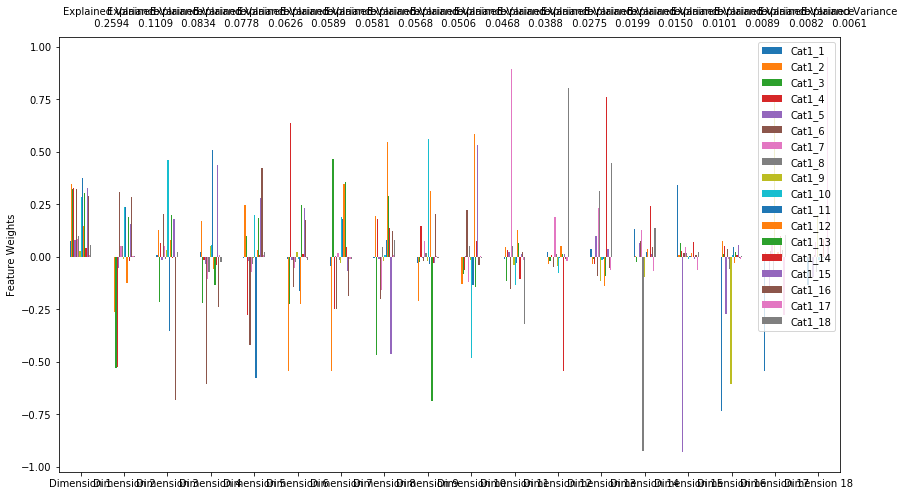

In [64]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
# Instantiate
pca = PCA(n_components=18)
# Fit
pca.fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

In [65]:
# DataFrame of results
display(pca_results)

# DataFrame
display(type(pca_results))

# Cumulative explained variance should add to 1
display(pca_results['Explained Variance'].cumsum())

,Explained Variance,Cat1_1,Cat1_2,Cat1_3,Cat1_4,Cat1_5,Cat1_6,Cat1_7,Cat1_8,Cat1_9,Cat1_10,Cat1_11,Cat1_12,Cat1_13,Cat1_14,Cat1_15,Cat1_16,Cat1_17,Cat1_18
Dimension 1,0.2594,0.0756,0.3496,0.3234,0.3280,0.0821,0.3233,0.0834,0.0993,0.0267,0.2832,0.3747,0.1483,0.3027,0.0411,0.3268,0.2919,0.0083,0.0554
Dimension 2,0.1109,0.0002,-0.2639,-0.5268,-0.5260,-0.0515,0.3102,0.0510,0.0539,-0.0078,0.2374,0.2368,-0.1260,0.1923,-0.0200,0.1580,0.2847,0.0054,0.0052
Dimension 3,0.0834,0.0100,0.1289,-0.2168,0.0680,-0.0149,0.2034,0.0508,-0.0086,0.0323,0.4636,-0.3533,0.0799,0.2017,-0.0036,0.1824,-0.6825,-0.0026,0.0214
Dimension 4,0.0778,0.0258,0.1710,-0.2215,-0.0138,-0.0352,-0.6068,-0.1043,-0.0708,0.0518,0.0571,0.5078,-0.0569,-0.1359,-0.0372,0.4377,-0.2373,0.0075,-0.0250
Dimension 5,0.0626,-0.0071,0.2468,0.1020,-0.2781,-0.0170,-0.4195,-0.0717,-0.0318,-0.0068,0.1977,-0.5775,0.0338,0.1865,0.0102,0.2814,0.4246,0.0101,0.0248
Dimension 6,0.0589,-0.0112,-0.5434,-0.2229,0.6381,-0.0150,-0.1414,-0.0520,-0.0242,0.0251,-0.0086,-0.1614,-0.2231,0.2479,0.0148,0.2353,0.1746,-0.0031,-0.0145
Dimension 7,0.0581,-0.0442,-0.5453,0.4665,-0.2492,0.0066,-0.2484,0.0208,-0.0142,-0.0297,0.1911,0.1793,0.3468,0.3564,0.0468,-0.0685,-0.1865,-0.0105,-0.0101
Dimension 8,0.0568,-0.0074,0.1965,-0.4662,0.1820,-0.0099,-0.2003,-0.1582,0.0455,-0.0203,0.0107,0.0798,0.5455,0.2916,0.1357,-0.4619,0.1248,0.0093,0.0815
Dimension 9,0.0506,-0.0309,-0.2077,-0.0265,0.1460,-0.0060,-0.0192,0.0750,0.0186,-0.0198,0.5598,-0.0332,0.3137,-0.6855,-0.0309,-0.0276,0.2063,0.0053,-0.0066
Dimension 10,0.0468,0.0015,-0.1278,-0.0818,-0.0622,0.0065,0.2229,-0.1173,0.0534,-0.0165,-0.4814,-0.1330,0.5870,-0.1430,0.0780,0.5333,-0.0381,0.0048,-0.0058


pandas.core.frame.DataFrame

Dimension 1     0.2594
Dimension 2     0.3703
Dimension 3     0.4537
Dimension 4     0.5315
Dimension 5     0.5941
Dimension 6     0.6530
Dimension 7     0.7111
Dimension 8     0.7679
Dimension 9     0.8185
Dimension 10    0.8653
Dimension 11    0.9041
Dimension 12    0.9316
Dimension 13    0.9515
Dimension 14    0.9665
Dimension 15    0.9766
Dimension 16    0.9855
Dimension 17    0.9937
Dimension 18    0.9998
Name: Explained Variance, dtype: float64

In [66]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,Dimension 11,Dimension 12,Dimension 13,Dimension 14,Dimension 15,Dimension 16,Dimension 17,Dimension 18
0,19.1191,0.3968,12.1776,6.3930,-2.7672,2.4707,2.4928,-5.8876,-4.9226,-3.0042,-3.9570,-2.4755,-3.6458,-2.7967,0.3673,-7.0111,8.5742,1.6225
1,13.7086,-10.3660,3.8845,-5.5341,-8.9114,-4.9736,6.8727,9.8815,-6.3926,4.1827,11.0829,-5.5962,9.3196,2.6238,0.3336,-0.9791,-2.9487,14.2513
2,-8.6682,-6.2526,3.0586,-6.0647,1.3147,-10.1008,-1.6501,-7.0401,-4.0342,-0.5020,-3.4070,-1.3137,-5.8624,12.8492,1.4290,1.5873,1.5203,0.9322


In [79]:
lst = []

for i in range(1,10):
    lst.append('Dimension '+str(i))
lst

['Dimension 1',
 'Dimension 2',
 'Dimension 3',
 'Dimension 4',
 'Dimension 5',
 'Dimension 6',
 'Dimension 7',
 'Dimension 8',
 'Dimension 9']

In [80]:
# TODO: Apply PCA by fitting the good data with only two dimensions
# Instantiate
pca = PCA(n_components=9)
pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = lst)

In [82]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = lst))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9
0,19.1191,0.3968,12.1776,6.3930,-2.7672,2.4707,2.4928,-5.8876,-4.9226
1,13.7086,-10.3660,3.8845,-5.5341,-8.9114,-4.9736,6.8727,9.8815,-6.3926
2,-8.6682,-6.2526,3.0586,-6.0647,1.3147,-10.1008,-1.6501,-7.0401,-4.0342


## Clustering

In [70]:
# Imports
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [71]:
# Create range of clusters 
range_n_clusters = list(range(2,11))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


In [72]:
# Loop through clusters
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.means_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='mahalanobis')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.34474496304274055
For n_clusters = 3. The average silhouette_score is : 0.38878449290732586
For n_clusters = 4. The average silhouette_score is : 0.37102188241515366
For n_clusters = 5. The average silhouette_score is : 0.3428495864473851
For n_clusters = 6. The average silhouette_score is : 0.30151397455357926
For n_clusters = 7. The average silhouette_score is : 0.24298390774000983
For n_clusters = 8. The average silhouette_score is : 0.2239635958734576
For n_clusters = 9. The average silhouette_score is : 0.16476608437634868
For n_clusters = 10. The average silhouette_score is : 0.36071305186393327


In [73]:
# Loop through clusters
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.4234097827686385
For n_clusters = 3. The average silhouette_score is : 0.3976436333290334
For n_clusters = 4. The average silhouette_score is : 0.4040697336973819
For n_clusters = 5. The average silhouette_score is : 0.3841937061994331
For n_clusters = 6. The average silhouette_score is : 0.38439717007059576
For n_clusters = 7. The average silhouette_score is : 0.39390837661987865
For n_clusters = 8. The average silhouette_score is : 0.3991503680100933
For n_clusters = 9. The average silhouette_score is : 0.4061800096246852
For n_clusters = 10. The average silhouette_score is : 0.4181635025355896


In [83]:
# Loop through clusters
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.means_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='mahalanobis')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.11929288865435957
For n_clusters = 3. The average silhouette_score is : 0.0961426617268333
For n_clusters = 4. The average silhouette_score is : 0.08228519359921198
For n_clusters = 5. The average silhouette_score is : 0.06016689480923633
For n_clusters = 6. The average silhouette_score is : 0.1187151389623392
For n_clusters = 7. The average silhouette_score is : 0.08451677226889945
For n_clusters = 8. The average silhouette_score is : 0.12335561601682403
For n_clusters = 9. The average silhouette_score is : 0.08072422092503487
For n_clusters = 10. The average silhouette_score is : 0.13874920513989408


In [84]:
# Loop through clusters
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.20617948122718563
For n_clusters = 3. The average silhouette_score is : 0.1661595780993171
For n_clusters = 4. The average silhouette_score is : 0.15275957192899284
For n_clusters = 5. The average silhouette_score is : 0.14741072521045323
For n_clusters = 6. The average silhouette_score is : 0.1499878941538061
For n_clusters = 7. The average silhouette_score is : 0.1544019513393843
For n_clusters = 8. The average silhouette_score is : 0.16062106004599003
For n_clusters = 9. The average silhouette_score is : 0.14370808405486193
For n_clusters = 10. The average silhouette_score is : 0.15894496070651262


In [85]:
# Extra code because we ran a loop on top and this resets to what we want
clusterer = GaussianMixture(n_components=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
sample_preds = clusterer.predict(pca_samples)

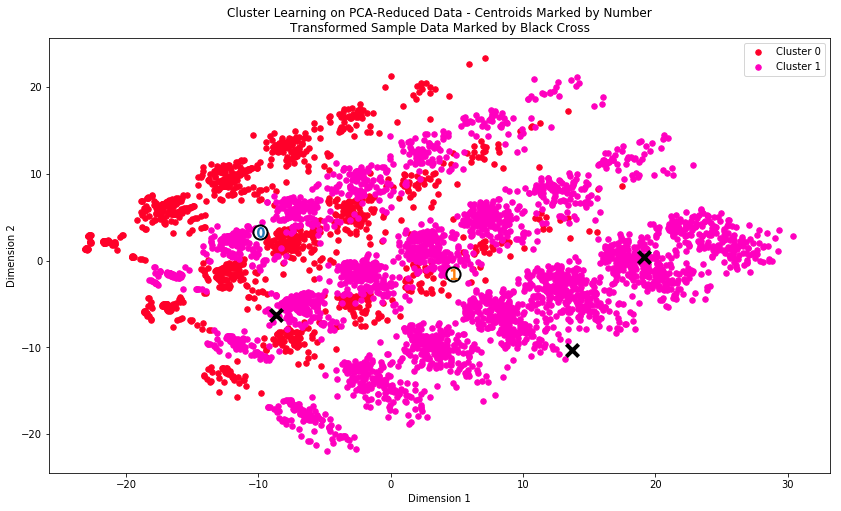

In [86]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

## A/B Testing on Groups